In [1]:
import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import numpy as np
import pandas as pd
import A1_provider_prep
import A2_other
import A3_analysis
from calitp.sql import to_snakecase
from calitp_data_analaysis import geography_utils, utils

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Save files to GCS
from calitp.storage import get_fs
fs = get_fs()

In [3]:
# Record start and end time
import datetime
from loguru import logger

In [4]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

### Function to find a specific file based on a string.

In [5]:
def find_specific_files(phrase_to_find:str):
    """
    Grab a list of files that contain the 
    phrase inputted.
    """
    # Create a list of all the files in my folder
    all_files_in_folder = fs.ls(A1_provider_prep.GCS_FILE_PATH)
    
    # Grab only files with the string "Verizon_no_coverage_"
    my_files = [i for i in all_files_in_folder if phrase_to_find in i]
    
    # String to add to read the files
    my_string = "gs://"
    my_files = [my_string + i for i in my_files]
   
    return my_files

### Function to clipped the sjoin result
* Created previously with `complete_difference_provider_district_level`.

In [6]:
def clip_sjoin_gdf(files_to_find:str, provider: str):
    """
    Provider maps were spatially joined against each Caltrans
    District. However, these sjoin gdfs include areas that don't belong 
    to that district, which throw off results.
    Clip these files by provider against the the original CT
    shapefile to clean up the edges. 
    
    files_to_find: find files that were spatially joined
    to the CT districts. 
    
    provider: the provider
    """
    # Open original Caltrans districts shapefile
    # Get rid of A1_provider_prep once I export this
    ct_districts = get_districts()
    
    # Get a list of files I want
    provider_files_list = find_specific_files(files_to_find)
    
    # Loop over every file
    # Put provider_files_list later.
    for file in provider_files_list:
        # Find which district each file contains. 
        # https://stackoverflow.com/questions/11339210/how-to-get-integer-values-from-a-string-in-python
        relevant_district = ''.join(i for i in file if i.isdigit())
        
        # Turn this into an integer
        relevant_district = int(relevant_district)
        
        # Filter out districts for the file's district
        relevant_district_gdf =  ct_districts[ct_districts.district == relevant_district]
        
        # Open file
        sjoin_file = gpd.read_parquet(file)
        
        # Clip the sjoin file against the original district shapefile
        clipped_gdf = sjoin_file.clip(relevant_district_gdf)
        
        # Save
        utils.geoparquet_gcs_export(clipped_gdf, GCS_FILE_PATH, f"{provider}_clip_d{relevant_district}")
        
        print(f"Done for {relevant_district}") 

In [7]:
# clip_sjoin_gdf("Verizon_d", "verizon")

### Function to dissolve the clipped results.
* Change from clipped_gdf to clipped_dask
* Add times: https://github.com/cal-itp/data-analyses/blob/main/high_quality_transit_areas/A2_combine_stops.py

In [8]:
def dissolve_clipped_gdf(phrase_to_find:str, provider: str):
    """
    Input files created by `clip_sjoin_gdf` 
    and dissolve all the rows by district.
    """
    # Get a list of files I want
    provider_files_list = find_specific_files(phrase_to_find)
    
    # Loop over every file
    # Put provider_files_list later.
    for file in provider_files_list:
        
        start = datetime.datetime.now()
        
        # Open file
        clipped_dask = dg.read_parquet(file)
        
        # Grab the district
        relevant_district = ''.join(i for i in file if i.isdigit())
        
        # Turn this into an integer for the file name
        relevant_district = int(relevant_district)
        
        # Dissolve by district
        dissolved_dask = clipped_dask.dissolve("district")
        
        # Turn back to gdf
        dissolved_gdf = dissolved_dask.compute()
        
        # Save
        utils.geoparquet_gcs_export(dissolved_gdf, GCS_FILE_PATH, f"{provider}_dissolve_d{relevant_district}")
        
        end = datetime.datetime.now()
        
        logger.info(f"execution time: {end-start}")
        print(f"Done for {relevant_district}") 

In [9]:
#2:35
# dissolve_clipped_gdf("verizon_clip_d", "verizon")

### Find Difference
* Take dissolved results and find the difference

In [10]:
def find_difference_gdf(phrase_to_find:str, provider: str):
    """
    Input the files created by `dissolve_clipped_gdf` 
    and find the difference with the original Caltrans
    district. 
    """
    # Open original Caltrans districts shapefile
    # Get rid of A1_provider_prep once I export this
    ct_districts = A1_provider_prep.get_districts()
    
    # Get a list of files I want
    provider_files_list = find_specific_files(phrase_to_find)
    
    start = datetime.datetime.now()
    
    # Loop over every file
    for file in provider_files_list:
        
        relevant_district = ''.join(i for i in file if i.isdigit())
        
        relevant_district = int(relevant_district)
        
        # Filter out districts for the file's district
        relevant_district_gdf =  ct_districts[ct_districts.district == relevant_district]
        
        # Open file
        dissolved_file = gpd.read_parquet(file)
        
        # Clip the dissolved file against the original district shapefile
        no_coverage = relevant_district_gdf.difference(dissolved_file.geometry.iloc[0]).reset_index()
        
        try:
            # Some are geodataframes without column names
            no_coverage = no_coverage.rename(columns = {0: 'geometry'})
            utils.geoparquet_gcs_export(no_coverage, A1_provider_prep.GCS_FILE_PATH, f"{provider}_difference_d{relevant_district}")
        except:
            # Some become geoseries - turn them into a gdf
            # https://gis.stackexchange.com/questions/266098/how-to-convert-a-geoseries-to-a-geodataframe-with-geopandas
            no_coverage_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(no_coverage))
            utils.geoparquet_gcs_export(no_coverage_gdf, A1_provider_prep.GCS_FILE_PATH, f"{provider}_difference_d{relevant_district}")
        
        print(f"Done for {relevant_district}") 
            
    end = datetime.datetime.now()
    logger.info(f"execution time: {end-start}")
        
    return no_coverage

In [11]:
# test = find_difference_gdf('verizon_dissolve_d','verizon')

### Stack the districts

In [12]:
# tmobile_difference = find_specific_files("tmobile_diff")

In [13]:
# tmobile_ca_map = dd.multi.concat([gpd.read_parquet(file) for file in tmobile_difference])

In [14]:
# tmobile_ca_map = tmobile_ca_map.compute()

In [1]:
def stack_all_maps(phrase_to_find:str, provider: str):
    """
    After running `find_difference_gdf`, the results are 
    seperated out by districts. Stack all the district files to create 
    one complete California file for this provider.
    """
    # Get a list of files I want
    provider_files_list = find_specific_files(phrase_to_find)
    
    start = datetime.datetime.now()
    
    # Concat files
    california_map = dd.multi.concat([gpd.read_parquet(file) for file in provider_files_list])
    california_map = california_map.compute()
    
    utils.geoparquet_gcs_export(california_map, GCS_FILE_PATH, f"{provider}_no_coverage_cal")
    
    end = datetime.datetime.now()
    logger.info(f"execution time: {end-start}")
        
    return california_map

In [20]:
# att_no_cov = stack_all_maps("att_difference", "att")

2023-01-12 10:14:05.157 | INFO     | __main__:stack_all_maps:23 - execution time: 0:00:12.474349


In [23]:
# verizon_no_cov = stack_all_maps("verizon_difference", "verizon")

2023-01-12 10:16:53.630 | INFO     | __main__:stack_all_maps:23 - execution time: 0:00:15.214112


In [27]:
# tmobile_no_cov = stack_all_maps("tmobile_difference", "tmobile")

2023-01-12 10:20:11.607 | INFO     | __main__:stack_all_maps:23 - execution time: 0:00:13.088378


### Test Areas
* Scratch area for previewing files and making sure the results are right.

In [26]:
verizon_no_cov.shape

(12, 2)

<AxesSubplot:>

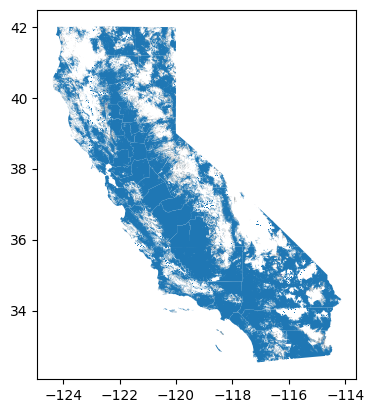

In [25]:
gpd.read_parquet("./Verizon.parquet").plot()

<AxesSubplot:>

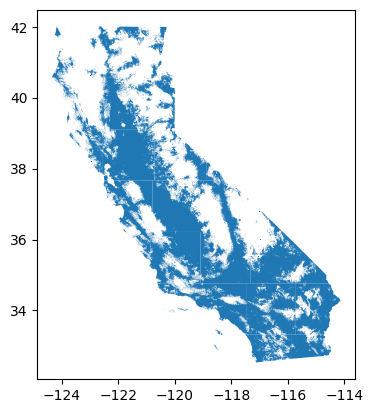

In [22]:
# Original ATT 
gpd.read_parquet("./ATT.parquet").plot()

<AxesSubplot:>

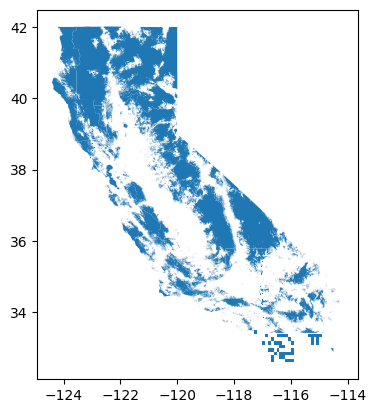

In [21]:
att_no_cov.plot()

In [ ]:
districts = A1_provider_prep.get_districts()

In [ ]:
d9 =  districts[districts.district == 9]

In [ ]:
d10 =  districts[districts.district == 10]

In [ ]:
d1 =  districts[districts.district == 1]

In [ ]:
# Dissolved T Mobile district 1 
tmobile_d1_diss = gpd.read_parquet("gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_dissolve_d1.parquet")

In [ ]:
# Dissolved T Mobile district 10
tmobile_d10_diss = gpd.read_parquet("gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_dissolve_d10.parquet")

In [ ]:
tmobile_d10_diss.shape

In [ ]:
# tmobile_d10_diss.plot()

In [ ]:
difference_tmobile_d10 = d10.difference(tmobile_d10_diss.geometry.iloc[0]).reset_index()

In [ ]:
type(difference_tmobile_d10)

In [ ]:
difference_tmobile_d1 = d1.difference(tmobile_d1_diss.geometry.iloc[0]).reset_index()

In [ ]:
type(difference_tmobile_d1)

In [ ]:
difference_tmobile_d1.plot()

In [ ]:
gdf_d1 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(difference_tmobile_d1))

In [ ]:
tmobile_d1_diss.plot()

In [ ]:
# Dissolved T Mobile district 9 
tmobile_d9_diss = gpd.read_parquet("gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_dissolve_d9.parquet")

In [ ]:
# Dissolved T Mobile district 9 
att_d10_diss = gpd.read_parquet("gs://calitp-analytics-data/data-analyses/cellular_coverage/att_dissolve_d10.parquet")

In [ ]:
att_d10_diss.shape, tmobile_d9_diss.shape

In [ ]:
# Now this is a geoseries
difference_tmobile_d9 = d9.difference(tmobile_d9_diss.geometry.iloc[0])

In [ ]:
type(difference_tmobile_d9)

In [ ]:
# Turn this to a gdf
# https://gis.stackexchange.com/questions/266098/how-to-convert-a-geoseries-to-a-geodataframe-with-geopandas
test_geo = gpd.GeoDataFrame(geometry=gpd.GeoSeries(difference_tmobile_d9))

In [ ]:
type(test_geo)

In [ ]:
# Test saving
test_geo.to_parquet("./test.parquet")

In [ ]:
test_geo.columns

In [ ]:
# Make sure it opens alright
my_gdf =  gpd.read_parquet("./test.parquet")

In [ ]:
type(my_gdf)

In [ ]:
my_gdf.plot()

In [ ]:
# difference_att_d10 = d10.difference(att_d10_diss.geometry.iloc[0])

In [ ]:
difference_tmobile_d9.plot()

In [ ]:
difference_att_d10.plot()

In [ ]:
# tmobile_d9_diss.shape

In [ ]:
# tmobile_d9.plot()

In [ ]:
att_d2 = gpd.read_parquet("gs://calitp-analytics-data/data-analyses/cellular_coverage/att_clip_d2.parquet")

In [ ]:
# att_d2.plot()